## Protein Hunter Boltz (Refiner)

In [ ]:
# @title 🧩 Setup and Core Imports
import os
from pathlib import Path
import warnings
import contextlib
import io
import copy
import yaml

import numpy as np
import pandas as pd
import torch
import random
from collections import defaultdict

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    message="torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*",
    category=UserWarning,
)

import py2Dmol
from LigandMPNN.wrapper import LigandMPNNWrapper

# --- New/Refactored Imports ---
from boltz_ph.constants import CHAIN_TO_NUMBER
from utils.metrics import get_CA_and_sequence # Used implicitly in design.py
from utils.convert import calculate_holo_apo_rmsd, convert_cif_files_to_pdb
# -----------------------------

from boltz_ph.model_utils import (
    binder_binds_contacts,
    extract_sequence_from_structure,
    clean_memory,
    design_sequence,
    get_boltz_model,
    get_cif,
    load_canonicals,
    plot_from_pdb,
    plot_run_metrics,
    process_msa,
    run_prediction,
    sample_seq,
    save_pdb,
    shallow_copy_tensor_dict,
    smart_split,
)
print("✅ Core functionality imported.")

In [ ]:
# @title 🧬 Boltz Configuration Parameters
# --- General Setup ---
gpu_id = 1  # @param {type:"integer"}
grad_enabled = False  # @param {type:"boolean"}
name = "PDL1_refiner_02"  # @param {type:"string"}
mode = "binder"  # @param ["unconditional", "binder"]
num_designs = 3  # @param {type:"integer"}
num_cycles = 5  # @param {type:"integer"}
save_dir = f"./results_boltz_refiner/{name}"
work_dir = os.getcwd()


# --- New Refiner/Cycling Input ---
# Path to the initial CIF or PDB file to start the refinement from
initial_design_path = "/home/jupyter-yehlin/ProteinHunter/example/rank03_5c3tprot_1.cif" ## e.g. cif or pdb file
binder_chain = "A"  # @param {type:"string"}
binder_seq = extract_sequence_from_structure(initial_design_path, binder_chain)
binder_length = len(binder_seq)

# --- Target Protein(s) ---
protein_ids = "B"  # @param {type:"string"}
protein_seqs = extract_sequence_from_structure(initial_design_path, protein_ids)  # @param {type:"string"}
protein_msas = (
    ""  # "" means generate, "empty" is single sequence # @param {type:"string"}
)
cyclics = ""  # @param {type:"string"}

# --- Non-Protein Components (Ligand/Nucleic Acid) ---
ligand_id = "C"
ligand_smiles = ""  # @param {type:"string"}
ligand_ccd = ""  # @param {type:"string"}
nucleic_type = "dna"
nucleic_id = ""
nucleic_seq = ""  # @param {type:"string"}

# --- Templates and Constraints ---
template_path = ""
template_chain_id = ""
add_constraints = False  # @param {type:"boolean"}
contact_residues = ""  # e.g., "1,2,5,10" on target chain # @param {type:"string"}
constraint_target_chain = "B"  # Target chain for contacts # @param {type:"string"}
contact_cutoff = 10.0  # @param {type:"number"}
max_contact_filter_retries = 6  # @param {type:"integer"}
no_contact_filter = False  # @param {type:"boolean"}

# --- Model & Diffusion Parameters ---
no_potentials = True  # @param {type:"boolean"}
diffuse_steps = 200  # @param {type:"integer"}
recycling_steps = 3  # @param {type:"integer"}
boltz_model_version = "boltz2"  # @param ["boltz1", "boltz2"]
boltz_model_path = os.path.expanduser("~/.boltz/boltz2_conf.ckpt")
ccd_path = Path(os.path.expanduser("~/.boltz/mols"))
logmd = False  # @param {type:"boolean"}

# --- Design & Optimization ---
randomly_kill_helix_feature = False  # @param {type:"boolean"}
negative_helix_constant = 0.0  # @param {type:"number"}
alanine_bias = True  # @param {type:"boolean"}
temperature_start = 0.05  # @param {type:"number"}
temperature_end = 0.001  # @param {type:"number"}
alanine_bias_start = -0.5  # @param {type:"number"}
alanine_bias_end = -0.2  # @param {type:"number"}
omit_AA = "C"  # @param {type:"string"}
exclude_P = False  # @param {type:"boolean"}
frac_X = 0.5  # @param {type:"number"}
high_iptm_threshold = 0.8  # @param {type:"number"}

# --- Optional: Validation Parameters (External Dependencies) ---
alphafold_dir = os.path.expanduser("~/alphafold3")
af3_docker_name = "alphafold3_yc"
af3_database_settings = os.path.expanduser("~/alphafold3/alphafold3_data_save")
hmmer_path = os.path.expanduser("~/.conda/envs/alphafold3_venv")
use_msa_for_af3 = False
plot = True  # @param {type:"boolean"}
viewer = True  # @param {type:"boolean"}


# Re-package parameters into an 'args' object (simple class for dot notation)
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = Args(**locals())

In [ ]:
# @title ⚙️ Initialize Models and Prepare Base Data
# --- 1. Model Initialization ---
device = (
    f"cuda:{args.gpu_id}" if torch.cuda.is_available() and args.gpu_id >= 0 else "cpu"
)
print(f"Using device: {device}")

predict_args = {
    "recycling_steps": args.recycling_steps,
    "sampling_steps": args.diffuse_steps,
    "diffusion_samples": 1,
    "write_confidence_summary": True,
    "write_full_pae": False,
    "write_full_pde": False,
    "max_parallel_samples": 1,
}

ccd_lib = load_canonicals(os.path.expanduser(str(args.ccd_path)))
boltz_model = get_boltz_model(
    checkpoint=args.boltz_model_path,
    predict_args=predict_args,
    device=device,
    model_version=args.boltz_model_version,
    no_potentials=args.no_potentials,
    grad_enabled=args.grad_enabled,
)
designer = LigandMPNNWrapper(os.path.join(args.work_dir, "./LigandMPNN/run.py"))
protein_hunter_save_dir = os.path.join(args.save_dir, "0_protein_hunter_design")
os.makedirs(protein_hunter_save_dir, exist_ok=True)
os.makedirs(args.save_dir, exist_ok=True)

# --- 2. Data Preparation (Condensed from _build_initial_data_dict) ---
sequences = []
# Process multi-chain/MSA inputs
protein_ids_list = smart_split(args.protein_ids)
protein_seqs_list = smart_split(args.protein_seqs)
protein_msas_list = (
    smart_split(args.protein_msas)
    if args.protein_msas
    else [""] * len(protein_ids_list)
)
cyclics_list = (
    smart_split(args.cyclics) if args.cyclics else ["False"] * len(protein_ids_list)
)

max_len = max(
    len(protein_ids_list),
    len(protein_seqs_list),
    len(protein_msas_list),
    len(cyclics_list),
)
for l in [protein_ids_list, protein_seqs_list, protein_msas_list, cyclics_list]:
    while len(l) < max_len:
        l.append("")

seq_to_indices = defaultdict(list)
for idx, seq in enumerate(protein_seqs_list):
    if seq:
        seq_to_indices[seq].append(idx)
seq_to_final_msa = {}

# Suppress MSA generation output during this phase
with contextlib.redirect_stdout(io.StringIO()) as f:
    for seq, idx_list in seq_to_indices.items():
        chosen_msa = next(
            (
                protein_msas_list[i]
                for i in idx_list
                if protein_msas_list[i] and protein_msas_list[i] != "empty"
            ),
            None,
        )
        if chosen_msa is None:
            chosen_msa = ""

        if chosen_msa == "":
            pid = (
                protein_ids_list[idx_list[0]]
                if protein_ids_list[idx_list[0]]
                else f"CHAIN_{idx_list[0]}"
            )
            msa_value = process_msa(pid, seq, Path(protein_hunter_save_dir))
            seq_to_final_msa[seq] = str(msa_value)
        elif chosen_msa == "empty":
            seq_to_final_msa[seq] = "empty"
        else:
            seq_to_final_msa[seq] = chosen_msa

# Build sequences list and add X-binder
for pid, seq, cyc in zip(protein_ids_list, protein_seqs_list, cyclics_list):
    if not pid or not seq:
        continue
    final_msa = seq_to_final_msa.get(seq, "empty")
    cyc_val = cyc.lower() in ["true", "1", "yes"]
    sequences.append(
        {"protein": {"id": [pid], "sequence": seq, "msa": final_msa, "cyclic": cyc_val}}
    )
sequences.append(
    {
        "protein": {
            "id": [args.binder_chain],
            "sequence": binder_seq,
            "msa": "empty",
            "cyclic": False,
        }
    }
)
if args.ligand_smiles:
    sequences.append({"ligand": {"id": [args.ligand_id], "smiles": args.ligand_smiles}})
elif args.ligand_ccd:
    sequences.append({"ligand": {"id": [args.ligand_id], "ccd": args.ligand_ccd}})
if args.nucleic_seq:
    sequences.append(
        {args.nucleic_type: {"id": [args.nucleic_id], "sequence": args.nucleic_seq}}
    )

# Handle templates and constraints
templates = []
if args.template_path:
    template_path_list = smart_split(args.template_path)
    template_chain_id_list = (
        smart_split(args.template_chain_id) if args.template_chain_id else []
    )
    template_files = [get_cif(tp) for tp in template_path_list]
    for i, template_file in enumerate(template_files):
        t_block = (
            {"cif": template_file}
            if template_file.endswith(".cif")
            else {"pdb": template_file}
        )
        if template_chain_id_list and i < len(template_chain_id_list):
            t_block["chain_id"] = template_chain_id_list[i]
        templates.append(t_block)

data = {"sequences": sequences}
if templates:
    data["templates"] = templates
pocket_conditioning = args.add_constraints

if args.add_constraints:
    residues = args.contact_residues.split(",")
    contacts = [
        [args.constraint_target_chain, int(res)]
        for res in residues
        if res.strip() != ""
    ]
    constraints = [{"pocket": {"binder": args.binder_chain, "contacts": contacts}}]
    data["constraints"] = constraints

data["sequences"] = sorted(
    data["sequences"], key=lambda entry: list(entry.values())[0]["id"][0]
)

any_ligand_or_nucleic = args.ligand_smiles or args.ligand_ccd or args.nucleic_seq
model_type = "ligand_mpnn" if any_ligand_or_nucleic else "soluble_mpnn"

print("✅ Models ready and base data configured.")
print("Mode:", args.mode)
print("Data dictionary (base):\n", data)

Using device: cuda:1
✅ Models ready and base data configured.
Mode: binder
Data dictionary (base):
 {'sequences': [{'protein': {'id': ['A'], 'sequence': 'SLKEEALKNIDKAIELVKKNLPEEIAKPIIELLKKAKEALEKGDYEKALENLNKALSLLLDHKDLLSEETYREILNNILNAIANLSKLL', 'msa': 'empty', 'cyclic': False}}, {'protein': {'id': ['B'], 'sequence': 'AFTVTVPKDLYVVEYGSNMTIECKFPVEKELDLAALIVYWEMEDKNIIQFVHGEEDLKVQHSSYRQRARLLKDQLSLGNAALQITDVKLQDAGVYRCMISYGGADYKRITVKVNAPYAAALEHHHH', 'msa': 'results_boltz_refiner/PDL1_refiner_02/0_protein_hunter_design/B_env/msa.npz', 'cyclic': False}}]}



=== Starting Design Run 0/2 ===
Binder initial sequence length: 89



--- Run 0, Cycle 1 ---
ipTM: 0.62, pLDDT: 0.95, iPLDDT: 0.94, Ala%: 9.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 0, Cycle 2 ---
ipTM: 0.87, pLDDT: 0.92, iPLDDT: 0.89, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 0, Cycle 3 ---
ipTM: 0.87, pLDDT: 0.96, iPLDDT: 0.96, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 0, Cycle 4 ---
ipTM: 0.88, pLDDT: 0.96, iPLDDT: 0.96, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 0, Cycle 5 ---
ipTM: 0.81, pLDDT: 0.92, iPLDDT: 0.89, Ala%: 9.0


<IPython.core.display.Javascript object>

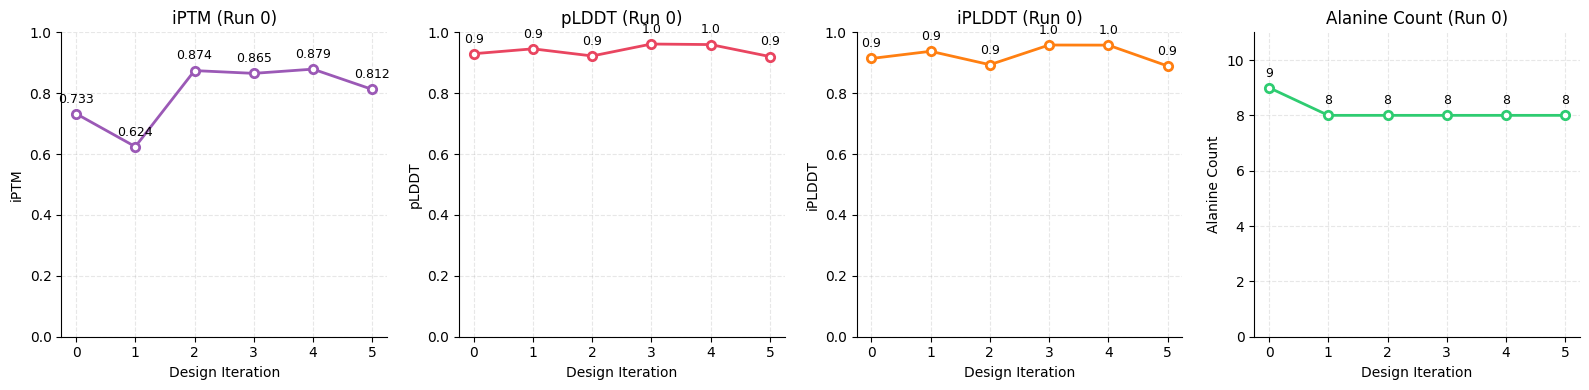


=== Starting Design Run 1/2 ===
Binder initial sequence length: 89

--- Run 1, Cycle 1 ---
ipTM: 0.91, pLDDT: 0.96, iPLDDT: 0.96, Ala%: 9.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 1, Cycle 2 ---
ipTM: 0.88, pLDDT: 0.96, iPLDDT: 0.96, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 1, Cycle 3 ---
ipTM: 0.91, pLDDT: 0.96, iPLDDT: 0.96, Ala%: 7.9


<IPython.core.display.Javascript object>


--- Run 1, Cycle 4 ---
ipTM: 0.80, pLDDT: 0.95, iPLDDT: 0.95, Ala%: 6.7


<IPython.core.display.Javascript object>


--- Run 1, Cycle 5 ---
ipTM: 0.44, pLDDT: 0.91, iPLDDT: 0.86, Ala%: 6.7


<IPython.core.display.Javascript object>

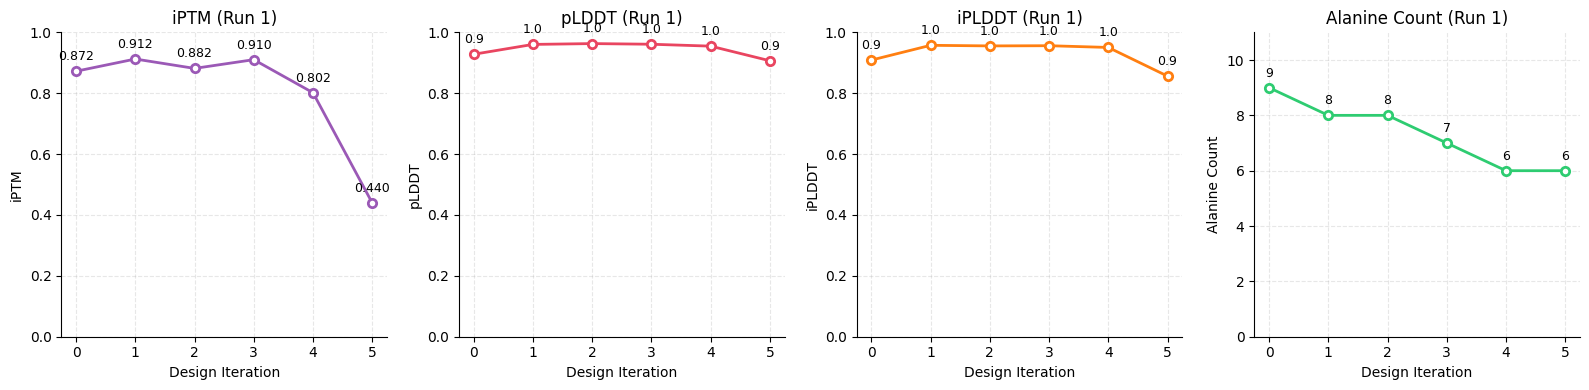


=== Starting Design Run 2/2 ===
Binder initial sequence length: 89

--- Run 2, Cycle 1 ---
ipTM: 0.69, pLDDT: 0.95, iPLDDT: 0.93, Ala%: 10.1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Run 2, Cycle 2 ---
ipTM: 0.56, pLDDT: 0.93, iPLDDT: 0.89, Ala%: 10.1


<IPython.core.display.Javascript object>


--- Run 2, Cycle 3 ---
ipTM: 0.63, pLDDT: 0.92, iPLDDT: 0.89, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 2, Cycle 4 ---
ipTM: 0.73, pLDDT: 0.91, iPLDDT: 0.86, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 2, Cycle 5 ---
ipTM: 0.79, pLDDT: 0.92, iPLDDT: 0.91, Ala%: 7.9


<IPython.core.display.Javascript object>

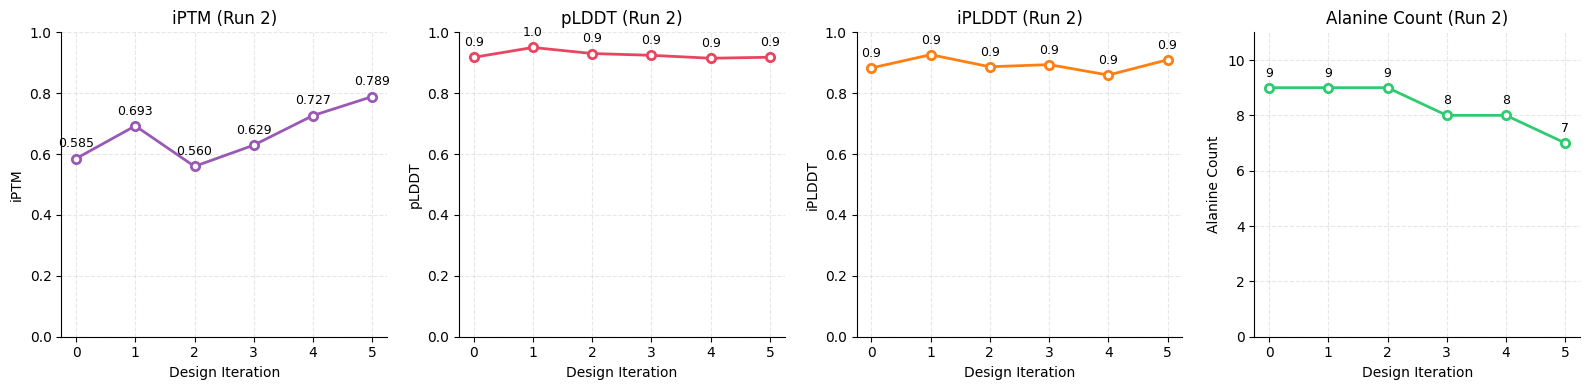


✅ All run/cycle metrics saved to ./results_boltz_refiner/PDL1_refiner_02/summary_all_runs.csv


In [ ]:
# @title 🚀 Execute Design and Optimization Loop (shortened)
import contextlib
import io

def compute_iptm(pair_chains, ref_chain_idx):
    if len(pair_chains) > 1:
        vals = [
            (
                pair_chains[ref_chain_idx][i].detach().cpu().numpy()
                + pair_chains[i][ref_chain_idx].detach().cpu().numpy()
            ) / 2.0
            for i in range(len(pair_chains)) if i != ref_chain_idx
        ]
        return float(np.mean(vals) if vals else 0.0)
    else:
        return 0.0

def get_float(item, key, default_val):
    return float(item.get(key, torch.tensor([default_val])).detach().cpu().numpy()[0])

all_run_metrics = []

for design_id in range(args.num_designs):
    if viewer:
        viewer = py2Dmol.view((600,400), color="plddt")
        viewer.show()

    run_id = str(design_id)
    run_save_dir = os.path.join(args.save_dir, f"run_{run_id}")
    os.makedirs(run_save_dir, exist_ok=True)
    data_cp = copy.deepcopy(data)
    print("\n" + "="*54)
    print(f"=== Starting Design Run {run_id}/{args.num_designs - 1} ===")
    print("="*54)

    best_iptm, best_seq, best_structure, best_output, best_pdb_filename = float("-inf"), None, None, None, None
    best_cycle_idx, best_alanine_percentage = -1, None
    run_metrics = {"run_id": run_id}
    print(f"Binder initial sequence length: {binder_length}")

    # --- Cycle 0 prediction ---
    with contextlib.redirect_stdout(io.StringIO()):
        output, structure = run_prediction(
            data_cp, args.binder_chain,
            randomly_kill_helix_feature=args.randomly_kill_helix_feature,
            negative_helix_constant=args.negative_helix_constant,
            boltz_model=boltz_model, ccd_lib=ccd_lib, ccd_path=args.ccd_path,
            logmd=args.logmd, device=device, boltz_model_version=args.boltz_model_version,
            pocket_conditioning=pocket_conditioning,
        )
    pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_0.pdb"
    save_pdb(structure, output["coords"], output["plddt"].detach().cpu().numpy()[0], pdb_filename)
    binder_chain_idx = CHAIN_TO_NUMBER[args.binder_chain]
    cycle_0_iptm = compute_iptm(output["pair_chains_iptm"], binder_chain_idx)
    run_metrics.update({
            "cycle_0_iptm": cycle_0_iptm,
            "cycle_0_plddt": get_float(output, "complex_plddt", 0.0),
            "cycle_0_iplddt": get_float(output, "complex_iplddt", 0.0),
            "cycle_0_alanine": binder_seq.count("A") if binder_length else 0.0,
            "cycle_0_seq": binder_seq
    })

    # --- Cycles 1...N with sequence/structure optimization
    for cycle in range(args.num_cycles):
        print(f"\n--- Run {run_id}, Cycle {cycle + 1} ---")
        cycle_norm = (cycle / (args.num_cycles - 1)) if args.num_cycles > 1 else 0.0
        alpha = args.alanine_bias_start - cycle_norm * (args.alanine_bias_start - args.alanine_bias_end)
        temperature = args.temperature_start - cycle_norm * (args.temperature_start - args.temperature_end)
        design_kwargs = {
            "pdb_file": pdb_filename,
            "temperature": temperature,
            "chains_to_design": args.binder_chain,
            "omit_AA": f"{args.omit_AA},P" if cycle == 0 else args.omit_AA,
        }
        if args.alanine_bias:
            design_kwargs["bias_AA"] = f"A:{alpha}"

        seq_str, logits = design_sequence(designer, model_type, **design_kwargs)
        seq = seq_str.split(":")[binder_chain_idx]
        alanine_count = seq.count("A")
        alanine_percentage = alanine_count / binder_length if binder_length else 0.0
        for seq_entry in data_cp["sequences"]:
            if "protein" in seq_entry and args.binder_chain in seq_entry["protein"]["id"]:
                seq_entry["protein"]["sequence"] = seq
                break

        with contextlib.redirect_stdout(io.StringIO()):
            output, structure = run_prediction(
                data_cp, args.binder_chain, seq=seq,
                randomly_kill_helix_feature=False, negative_helix_constant=0.0,
                boltz_model=boltz_model, ccd_lib=ccd_lib, ccd_path=args.ccd_path,
                logmd=False, device=device,
            )
        current_iptm = compute_iptm(output["pair_chains_iptm"], binder_chain_idx)

        if alanine_percentage <= 0.20 and current_iptm > best_iptm:
            best_iptm, best_structure = current_iptm, copy.deepcopy(structure)
            best_output = shallow_copy_tensor_dict(output)
            best_pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_best_structure.pdb"
            save_pdb(best_structure, best_output["coords"],
                     best_output["plddt"].detach().cpu().numpy()[0], best_pdb_filename)
            best_cycle_idx, best_seq = cycle + 1, seq
            best_alanine_percentage = alanine_percentage

        curr_plddt = get_float(output, "complex_plddt", 0.0)
        curr_iplddt = get_float(output, "complex_iplddt", 0.0)
        run_metrics.update({
            f"cycle_{cycle + 1}_iptm": current_iptm,
            f"cycle_{cycle + 1}_plddt": curr_plddt,
            f"cycle_{cycle + 1}_iplddt": curr_iplddt,
            f"cycle_{cycle + 1}_alanine": alanine_count,
            f"cycle_{cycle + 1}_seq": seq
        })

        print(f"ipTM: {current_iptm:.2f}, pLDDT: {curr_plddt:.2f}, iPLDDT: {curr_iplddt:.2f}, Ala%: {alanine_percentage * 100:.1f}")

        pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_{cycle + 1}.pdb"
        save_pdb(structure, output["coords"], output["plddt"].detach().cpu().numpy()[0], pdb_filename)
        if viewer:
            viewer.add_pdb(pdb_filename)
        clean_memory()

    # --- Finalize & plot metrics
    run_metrics.update({
        "best_iptm": float(best_iptm if best_iptm != float("-inf") else np.nan),
        "best_cycle": best_cycle_idx,
        "best_seq": best_seq,
        "best_plddt": float(best_output.get("complex_plddt", torch.tensor([np.nan])).detach().cpu().numpy()[0])
            if best_output else np.nan
    })
    all_run_metrics.append(run_metrics)
    if args.plot:
        plot_run_metrics(run_save_dir, args.name, run_id, args.num_cycles, run_metrics)

# -- Save all metrics to CSV --
summary_csv = os.path.join(args.save_dir, "summary_all_runs.csv")
df = pd.DataFrame(all_run_metrics)
columns = ["run_id"] + [
    f"{metric}{cycle_suffix}"
    for cycle_suffix in [f"_{i}" for i in range(args.num_cycles + 1)]
    for metric in ["cycle_iptm", "cycle_plddt", "cycle_iplddt", "cycle_alanine", "cycle_seq"]
]
columns = [col.replace("cycle_", f"cycle_{i}_") if "cycle_" in col else col for i in range(args.num_cycles + 1) for col in columns if f"_{i}_" in col or col == "run_id"]
columns = sorted(set(columns), key=columns.index)  # keep order, remove dupes
columns.extend(["best_iptm", "best_cycle", "best_plddt", "best_seq"])

for col in columns:
    if col not in df.columns:
        df[col] = np.nan
df = df[[c for c in columns if c in df.columns]]
df.to_csv(summary_csv, index=False)
print(f"\n✅ All run/cycle metrics saved to {summary_csv}")

In [ ]:
# # @title ⚙️ Optional: Downstream Validation (Requires External Setup)
# # Determine target type
# from utils.alphafold_utils import run_alphafold_step
# from utils.pyrosetta_utils import run_rosetta_step

# target_type = "protein"
# if args.nucleic_seq:
#     target_type = "nucleic"
# elif args.ligand_smiles or args.ligand_ccd:
#     target_type = "small_molecule"

# success_dir = os.path.join(args.save_dir, "1_af3_rosetta_validation")
# high_iptm_yaml_dir = os.path.join(args.save_dir, "high_iptm_yaml")

# # AlphaFold step
# af_output_dir, af_output_apo_dir, af_pdb_dir, af_pdb_dir_apo = run_alphafold_step(
#     high_iptm_yaml_dir,
#     args.alphafold_dir,
#     args.af3_docker_name,
#     args.af3_database_settings,
#     args.hmmer_path,
#     success_dir,
#     args.work_dir,
#     binder_id=args.binder_chain,
#     gpu_id=args.gpu_id,
#     high_iptm=True,
#     use_msa_for_af3=args.use_msa_for_af3,
# )

# # Rosetta step
# run_rosetta_step(
#     success_dir,
#     af_pdb_dir,
#     af_pdb_dir_apo,
#     binder_id=args.binder_chain,
#     target_type=target_type,
# )

# print("✅ Pipeline execution complete. Check results in the output directory.")